In [ ]:
# Lendo os dados
import pandas as pd
df_train = pd.read_csv("train_churn_.csv", sep=';')
df_test = pd.read_csv("test_churn_.csv")
sample_submission = pd.read_csv("sample_submission_.csv")

In [ ]:
# Tratando valores nulos e removendo coluna que não será utilizada na base de teste
df_train.replace('', pd.NA, inplace=True)
df_train.replace(' ', pd.NA, inplace=True)
df_train.fillna(0,inplace=True)
df_train.drop('Unnamed: 0',axis=1,inplace=True)

In [ ]:
# Transformando colunas com números para numéricas
df_train['idoso'] = df_train['idoso'].astype(int)
df_train['FaturaMensal'] = df_train['FaturaMensal'].astype(float)
df_train['FaturaTotal'] = df_train['FaturaTotal'].astype(float)
df_train['NumTickets'] = df_train['NumTickets'].astype(int)
df_train['NumTicketsTecnico'] = df_train['NumTicketsTecnico'].astype(int)
df_train['Churn'] = df_train['Churn'].astype(int)

In [ ]:
# Padronizando colunas binárias para 0 e 1
df_train['genero'] = df_train['genero'].replace({'Masculino':1,'Feminino':0})
df_train['parceiro'] = df_train['parceiro'].replace({'Sim':1,'Não':0})
df_train['ServicoTelefone'] = df_train['ServicoTelefone'].replace({'Sim':1,'Não':0})
df_train['dependentes'] = df_train['dependentes'].replace({'Sim':1,'Não':0})
df_train['BillingDigital'] = df_train['BillingDigital'].replace({'Sim':1,'Não':0})

In [ ]:
# Listar colunas categóricas
categorical_columns = ['MultiLinhas',
                       'ServicoInternet', 'ServicoSegurancaCyber', 'ServicoBackup',
                       'SeguroDispositivos', 'ServicoSuporteTecnico', 'StreamingTV',
                       'StreamingFilmes', 'Contrato', 'MetodoPagamento']
# Aplicar One-Hot Encoding nas variáveis categóricas
df_train = pd.get_dummies(df_train, columns=categorical_columns, drop_first=True)
# Padronizar colunas com 0 e 1
df_train.replace({True:1,False:0},inplace=True)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# Normalizar colunas float
float_columns = df_train.select_dtypes(include=['float64']).columns
scaler = StandardScaler()
df_train[float_columns] = scaler.fit_transform(df_train[float_columns])
# Dividir o dataset em treino e validação
X = df_train.drop('Churn', axis=1)
y = df_train['Churn']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score
# Definir o modelo
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
# Definir o espaço de busca dos hiperparâmetros
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}
# Usar RandomizedSearchCV para encontrar os melhores hiperparâmetros
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_distributions,
                                   n_iter=50, scoring='roc_auc', cv=3, verbose=2, random_state=42, n_jobs=-1)
# Treinar o modelo
random_search.fit(X_train, y_train)
# Melhor conjunto de hiperparâmetros
best_params = random_search.best_params_
print("Melhores hiperparâmetros:", best_params)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Melhores hiperparâmetros: {'subsample': 0.7, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


Acurácia na base de treino: 0.89125
Acurácia na base de teste: 0.83


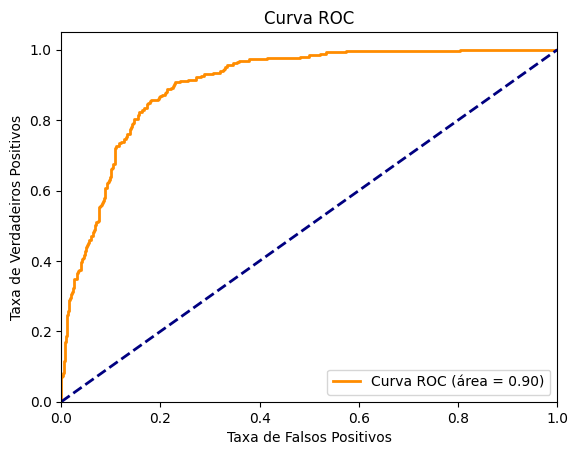

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
# Definir o modelo com os melhores hiperparâmetros
best_xgb_model = xgb.XGBClassifier(
    subsample=0.8,
    n_estimators=500,
    max_depth=5,
    learning_rate=0.01,
    colsample_bytree=1.0,
    use_label_encoder=False,
    eval_metric='logloss'
)
# Treinar o modelo
best_xgb_model.fit(X_train, y_train)
y_train_pred = best_xgb_model.predict(X_train)
y_val_pred = best_xgb_model.predict(X_val)

# Calcular a acurácia na base de treino e validação
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
# Exibir a acurácia
print("Acurácia na base de treino:", train_accuracy)
print("Acurácia na base de teste:", val_accuracy)
# Curva ROC
y_pred_proba = best_xgb_model.predict_proba(X_val)[:, 1]
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)
# Plotar a curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

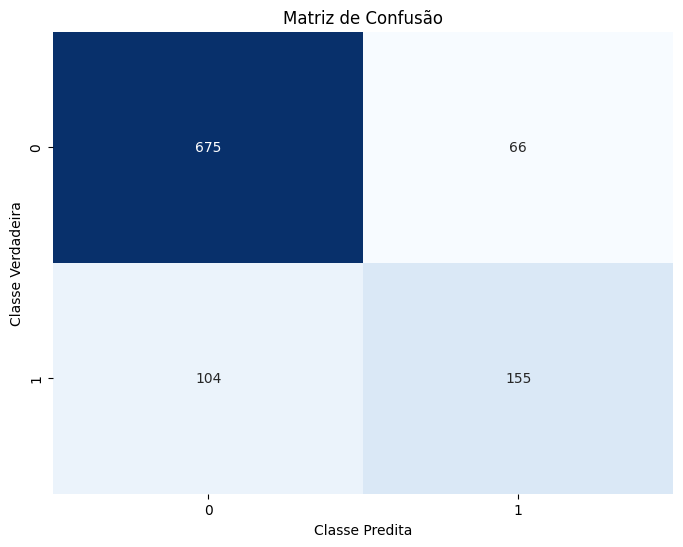

In [ ]:
# Matriz de confusão
conf_matrix = confusion_matrix(y_val, y_val_pred)
# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Classe Predita')
plt.ylabel('Classe Verdadeira')
plt.title('Matriz de Confusão')
plt.show()

# Chegamos a conclusão de uma acurácia de 83% na base de teste e que o modelo está acertando mais os verdadeiros negativos.

In [ ]:
# Tratando valores nulos e removendo coluna que não será utilizada na base de teste
df_test.replace('', pd.NA, inplace=True)
df_test.replace(' ', pd.NA, inplace=True)
df_test.fillna(0,inplace=True)
df_test.drop('Unnamed: 0',axis=1,inplace=True)
df_test.drop('index',axis=1,inplace=True)

In [ ]:
# Transformando colunas com números para numéricas
df_test['idoso'] = df_test['idoso'].astype(int)
df_test['FaturaMensal'] = df_test['FaturaMensal'].astype(float)
df_test['FaturaTotal'] = df_test['FaturaTotal'].astype(float)
df_test['NumTickets'] = df_test['NumTickets'].astype(int)
df_test['NumTicketsTecnico'] = df_test['NumTicketsTecnico'].astype(int)

In [ ]:
# Padronizando colunas binárias para 0 e 1
df_test['genero'] = df_test['genero'].replace({'Masculino':1,'Feminino':0})
df_test['parceiro'] = df_test['parceiro'].replace({'Sim':1,'Não':0})
df_test['ServicoTelefone'] = df_test['ServicoTelefone'].replace({'Sim':1,'Não':0})
df_test['dependentes'] = df_test['dependentes'].replace({'Sim':1,'Não':0})
df_test['BillingDigital'] = df_test['BillingDigital'].replace({'Sim':1,'Não':0})

In [ ]:
# Listar colunas categóricas
categorical_columns = ['MultiLinhas',
                       'ServicoInternet', 'ServicoSegurancaCyber', 'ServicoBackup',
                       'SeguroDispositivos', 'ServicoSuporteTecnico', 'StreamingTV',
                       'StreamingFilmes', 'Contrato', 'MetodoPagamento']
# Aplicar One-Hot Encoding nas variáveis categóricas
df_test = pd.get_dummies(df_test, columns=categorical_columns, drop_first=True)
# Padronizar colunas com 0 e 1
df_test.replace({True:1,False:0},inplace=True)

In [ ]:
# Normalizar colunas float
float_columns = df_test.select_dtypes(include=['float64']).columns
scaler = StandardScaler()
df_test[float_columns] = scaler.fit_transform(df_test[float_columns])

In [ ]:
# Fazer previsões na base de teste
predictions = best_xgb_model.predict(df_test)
predictions_proba = best_xgb_model.predict_proba(df_test)[:, 1]